In [3]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


In [5]:
print(device)

cuda:0


In [6]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [7]:
load_network_path = 'checkpoints/best_detector.pth' 
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from checkpoints/best_detector.pth


In [9]:
learning_rate = 0.001
num_epochs = 50
# num_epochs = 15
batch_size = 12 # I changed this to 6 coz of cuda mem error, was initally 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

In [10]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [11]:
file_root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [12]:
data = train_dataset[0]

## Set up training tools

In [11]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [12]:
torch.cuda.empty_cache()

In [13]:
if torch.cuda.is_available():
    !nvidia-smi

Thu Apr  4 13:29:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P4                       On  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              23W /  75W |    278MiB /  7680MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
best_test_loss = np.inf
learning_rate = 1e-3

for epoch in range(num_epochs):
#     torch.cuda.empty_cache()
    net.train()
    
    # Updating learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
#             print(loss_dict[key])
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluating the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')
    
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')
    




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/418], Loss: total=23.888, reg=4.026, containing_obj=0.304, no_obj=12.451, cls=7.107
Epoch [1/50], Iter [100/418], Loss: total=16.226, reg=3.560, containing_obj=0.389, no_obj=6.451, cls=5.826
Epoch [1/50], Iter [150/418], Loss: total=13.354, reg=3.304, containing_obj=0.455, no_obj=4.405, cls=5.190
Epoch [1/50], Iter [200/418], Loss: total=11.644, reg=3.089, containing_obj=0.501, no_obj=3.365, cls=4.688
Epoch [1/50], Iter [250/418], Loss: total=10.516, reg=2.935, containing_obj=0.537, no_obj=2.733, cls=4.311
Epoch [1/50], Iter [300/418], Loss: total=9.649, reg=2.803, containing_obj=0.558, no_obj=2.307, cls=3.980
Epoch [1/50], Iter [350/418], Loss: total=9.026, reg=2.714, containing_obj=0.580, no_obj=2.000, cls=3.731
Epoch [1/50], Iter [400/418], Loss: total=8.545, reg=2.637, containing_obj=0.603, no_obj=1.768, cls=3.537
Updating best test loss: 5.06459


Starting epoch 2 / 50
Learning Rate for this epoch: 

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:55<00:00, 28.21it/s]


---class aeroplane ap 0.21398449685127763---
---class bicycle ap 0.20273971446038702---
---class bird ap 0.11368936606772628---
---class boat ap 0.029810019355139928---
---class bottle ap 0.0004488834025361912---
---class bus ap 0.03610288587123279---
---class car ap 0.26298736984200344---
---class cat ap 0.24856604691676001---
---class chair ap 0.08398585568185919---
---class cow ap 0.06242418466017398---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.12333473926719814---
---class horse ap 0.312138496767899---
---class motorbike ap 0.07984162895927602---
---class person ap 0.19387656920732965---
---class pottedplant ap 0.014093244876135608---
---class sheep ap 0.028561272549542348---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.17765563945373913---
---class tvmonitor ap 0.16097746740546165---
---map 0.1172608940797839---
4 [0.21398449685127763, 0.20273971446038702, 0.11368936606772628, 0.029810019355139928, 0.00044888340

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:57<00:00, 27.85it/s]


---class aeroplane ap 0.24337320215809438---
---class bicycle ap 0.3506127759897346---
---class bird ap 0.2524699655703556---
---class boat ap 0.07495758701165235---
---class bottle ap 0.06277007440400252---
---class bus ap 0.36955159430183265---
---class car ap 0.37834630288659743---
---class cat ap 0.48903344600389675---
---class chair ap 0.15585495122070078---
---class cow ap 0.25956446771471553---
---class diningtable ap 0.04223300970873786---
---class dog ap 0.4429741858647115---
---class horse ap 0.477833481302995---
---class motorbike ap 0.303353025442281---
---class person ap 0.301304936601384---
---class pottedplant ap 0.06627374694057421---
---class sheep ap 0.1090795366017946---
---class sofa ap 0.1939359796086249---
---class train ap 0.48810429381305254---
---class tvmonitor ap 0.27522239276509275---
---map 0.26684244779554156---
9 [0.24337320215809438, 0.3506127759897346, 0.2524699655703556, 0.07495758701165235, 0.06277007440400252, 0.36955159430183265, 0.37834630288659743

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:06<00:00, 26.52it/s]


---class aeroplane ap 0.454965006723661---
---class bicycle ap 0.4824655235109986---
---class bird ap 0.41560549354076287---
---class boat ap 0.2269154744218701---
---class bottle ap 0.13271130953509808---
---class bus ap 0.5053851121671863---
---class car ap 0.6103689693778052---
---class cat ap 0.6245300983475452---
---class chair ap 0.20607427289323488---
---class cow ap 0.3412147454670146---
---class diningtable ap 0.18540293673936478---
---class dog ap 0.5455796773169036---
---class horse ap 0.5696379058737183---
---class motorbike ap 0.5082543233407755---
---class person ap 0.42793311795116706---
---class pottedplant ap 0.08252081042553516---
---class sheep ap 0.3894596055614131---
---class sofa ap 0.3553429422299585---
---class train ap 0.5230489027456768---
---class tvmonitor ap 0.4703448460203911---
---map 0.40288805370950403---
14 [0.454965006723661, 0.4824655235109986, 0.41560549354076287, 0.2269154744218701, 0.13271130953509808, 0.5053851121671863, 0.6103689693778052, 0.624

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:09<00:00, 26.07it/s]


---class aeroplane ap 0.40069319842193624---
---class bicycle ap 0.545426236851295---
---class bird ap 0.3539943470035679---
---class boat ap 0.21392644762443633---
---class bottle ap 0.18440020832933912---
---class bus ap 0.5513092642617852---
---class car ap 0.6150465618445999---
---class cat ap 0.658332726651587---
---class chair ap 0.20552789290896206---
---class cow ap 0.38649607923201057---
---class diningtable ap 0.29410079882113166---
---class dog ap 0.5561094014846637---
---class horse ap 0.6301097792982627---
---class motorbike ap 0.4863888625285442---
---class person ap 0.5023998616969308---
---class pottedplant ap 0.1266840227858751---
---class sheep ap 0.3567491710693856---
---class sofa ap 0.3621152047182575---
---class train ap 0.5531972468369428---
---class tvmonitor ap 0.4991766930136228---
---map 0.42410920026915677---
19 [0.40069319842193624, 0.545426236851295, 0.3539943470035679, 0.21392644762443633, 0.18440020832933912, 0.5513092642617852, 0.6150465618445999, 0.658

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:09<00:00, 26.10it/s]


---class aeroplane ap 0.43732917790685233---
---class bicycle ap 0.5298359133009254---
---class bird ap 0.49590392252625304---
---class boat ap 0.24686635453654535---
---class bottle ap 0.19006797252500274---
---class bus ap 0.6200361104991676---
---class car ap 0.6473887192394242---
---class cat ap 0.6771558061108927---
---class chair ap 0.24225431415387128---
---class cow ap 0.4284976405307309---
---class diningtable ap 0.35690549659032755---
---class dog ap 0.5891785620487187---
---class horse ap 0.5847813495586569---
---class motorbike ap 0.523751541300761---
---class person ap 0.5133197558345821---
---class pottedplant ap 0.1401507062041727---
---class sheep ap 0.4025740149064799---
---class sofa ap 0.433591509046416---
---class train ap 0.5904582311351019---
---class tvmonitor ap 0.462098224971651---
---map 0.4556072661463267---
24 [0.43732917790685233, 0.5298359133009254, 0.49590392252625304, 0.24686635453654535, 0.19006797252500274, 0.6200361104991676, 0.6473887192394242, 0.677

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:08<00:00, 26.25it/s]


---class aeroplane ap 0.42880522202335697---
---class bicycle ap 0.5571427773369193---
---class bird ap 0.4908643878157544---
---class boat ap 0.2852148796788813---
---class bottle ap 0.19944900000254406---
---class bus ap 0.6079286093631227---
---class car ap 0.6122413686624284---
---class cat ap 0.6503020675165619---
---class chair ap 0.25811501077217525---
---class cow ap 0.44655774624367417---
---class diningtable ap 0.28705394506504905---
---class dog ap 0.5343006407000976---
---class horse ap 0.6281742244218471---
---class motorbike ap 0.5771581829245154---
---class person ap 0.4850260668227518---
---class pottedplant ap 0.14034094907053576---
---class sheep ap 0.4502058910420977---
---class sofa ap 0.383583138447264---
---class train ap 0.6032653653794388---
---class tvmonitor ap 0.47922264351079136---
---map 0.4552476058399903---
29 [0.42880522202335697, 0.5571427773369193, 0.4908643878157544, 0.2852148796788813, 0.19944900000254406, 0.6079286093631227, 0.6122413686624284, 0.65

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:06<00:00, 26.61it/s]


---class aeroplane ap 0.47252801189262494---
---class bicycle ap 0.597807725636748---
---class bird ap 0.5293392795022624---
---class boat ap 0.31932385446853623---
---class bottle ap 0.22613628970381633---
---class bus ap 0.6757714551254379---
---class car ap 0.6597805205765052---
---class cat ap 0.7002272659303493---
---class chair ap 0.3048505093786378---
---class cow ap 0.4953024535941039---
---class diningtable ap 0.3891723003479646---
---class dog ap 0.6395591149008548---
---class horse ap 0.6741487376199076---
---class motorbike ap 0.6081626234306878---
---class person ap 0.5364001007809085---
---class pottedplant ap 0.17556678554032476---
---class sheep ap 0.5212829571335373---
---class sofa ap 0.5052100858568147---
---class train ap 0.6320478913668---
---class tvmonitor ap 0.5717164488891734---
---map 0.5117167205837998---
34 [0.47252801189262494, 0.597807725636748, 0.5293392795022624, 0.31932385446853623, 0.22613628970381633, 0.6757714551254379, 0.6597805205765052, 0.70022726

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:05<00:00, 26.69it/s]


---class aeroplane ap 0.49616301247746164---
---class bicycle ap 0.5923006482324132---
---class bird ap 0.5155847236641329---
---class boat ap 0.33671923220309186---
---class bottle ap 0.2230066062658404---
---class bus ap 0.6575081743546589---
---class car ap 0.6736496962396206---
---class cat ap 0.7110283331652262---
---class chair ap 0.3239156000188432---
---class cow ap 0.525982004940148---
---class diningtable ap 0.4352141832103449---
---class dog ap 0.6562415394241015---
---class horse ap 0.6947213810889286---
---class motorbike ap 0.6061697326484564---
---class person ap 0.5450528030303873---
---class pottedplant ap 0.16957070427401638---
---class sheep ap 0.5080603506661906---
---class sofa ap 0.5117838953759003---
---class train ap 0.6601012453742386---
---class tvmonitor ap 0.5565592877945723---
---map 0.5199666577224288---
39 [0.49616301247746164, 0.5923006482324132, 0.5155847236641329, 0.33671923220309186, 0.2230066062658404, 0.6575081743546589, 0.6736496962396206, 0.711028

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:05<00:00, 26.62it/s]


---class aeroplane ap 0.5078828315042998---
---class bicycle ap 0.6074818896788388---
---class bird ap 0.5218734125234935---
---class boat ap 0.34334173013017---
---class bottle ap 0.24446657737679067---
---class bus ap 0.6645194080830817---
---class car ap 0.6777474671279973---
---class cat ap 0.7169747698576279---
---class chair ap 0.31532763766076893---
---class cow ap 0.5406769212598542---
---class diningtable ap 0.42718794703600615---
---class dog ap 0.6681170335092135---
---class horse ap 0.6902345281767752---
---class motorbike ap 0.6183872739350769---
---class person ap 0.5486793828307472---
---class pottedplant ap 0.18126025711498447---
---class sheep ap 0.5137373217389197---
---class sofa ap 0.5191372876576784---
---class train ap 0.657275157239823---
---class tvmonitor ap 0.5446990120526908---
---map 0.5254503923247419---
44 [0.5078828315042998, 0.6074818896788388, 0.5218734125234935, 0.34334173013017, 0.24446657737679067, 0.6645194080830817, 0.6777474671279973, 0.7169747698

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:07<00:00, 26.46it/s]


---class aeroplane ap 0.5007177457677563---
---class bicycle ap 0.6026628815705897---
---class bird ap 0.5214413486357801---
---class boat ap 0.32979996686347335---
---class bottle ap 0.24985373158281912---
---class bus ap 0.6644381857201804---
---class car ap 0.6787382266408205---
---class cat ap 0.7202723531749665---
---class chair ap 0.3209539532282755---
---class cow ap 0.5342784916366009---
---class diningtable ap 0.4348392671511815---
---class dog ap 0.6661513252073198---
---class horse ap 0.7015330885108587---
---class motorbike ap 0.628949229248479---
---class person ap 0.5531738826259747---
---class pottedplant ap 0.18397291768641466---
---class sheep ap 0.5088777450198192---
---class sofa ap 0.5230337457738314---
---class train ap 0.6581136424455735---
---class tvmonitor ap 0.5605031684452253---
---map 0.5271152448467971---
49 [0.5007177457677563, 0.6026628815705897, 0.5214413486357801, 0.32979996686347335, 0.24985373158281912, 0.6644381857201804, 0.6787382266408205, 0.720272

# View example predictions

predicting...


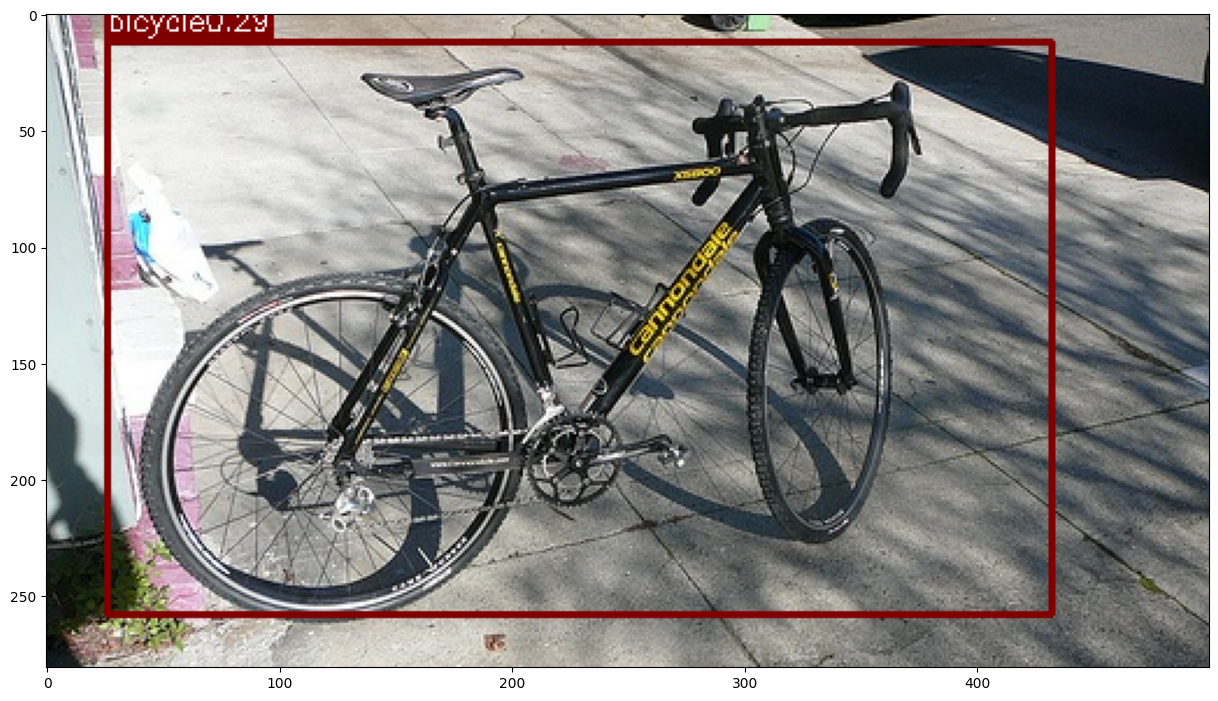

In [18]:
net.eval()

# selecting random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [18]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [03:06<00:00, 26.57it/s]


---class aeroplane ap 0.5007177457677563---
---class bicycle ap 0.6026628815705897---
---class bird ap 0.5214413486357801---
---class boat ap 0.32979996686347335---
---class bottle ap 0.24985373158281912---
---class bus ap 0.6644381857201804---
---class car ap 0.6787382266408205---
---class cat ap 0.7202723531749665---
---class chair ap 0.3209539532282755---
---class cow ap 0.5342784916366009---
---class diningtable ap 0.4348392671511815---
---class dog ap 0.6661513252073198---
---class horse ap 0.7015330885108587---
---class motorbike ap 0.628949229248479---
---class person ap 0.5531738826259747---
---class pottedplant ap 0.18397291768641466---
---class sheep ap 0.5088777450198192---
---class sofa ap 0.5230337457738314---
---class train ap 0.6581136424455735---
---class tvmonitor ap 0.5605031684452253---
---map 0.5271152448467971---
